In [964]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.optimize import minimize
import random

In [965]:
rdf = pd.read_csv('winequality-red.csv', sep=';')


Here we will do a 75%-15%-10% test split for train-validation-test respectively

In [966]:
rdf_train, rdf_val = train_test_split(rdf, test_size=0.25, random_state=50)
rdf_val, rdf_test = train_test_split(rdf_val, test_size=0.4, random_state=50)

In [967]:
X_train = rdf_train.drop('quality', axis=1)
y_train = rdf_train['quality']
X_test = rdf_test.drop('quality', axis=1)
y_test = rdf_test['quality']

Standardization:
$\mu_j$ is the mean and $\sigma_j$ is the standard deviation of feature $j$ across all data points. Each sample $x_n$ in each feature is replaced as follows:
$(x_n)_j \leftarrow \frac{(x_n)_j - \mu_j}{\sigma_j}$

Normalization:
$M_j$ and $m_j$ denote the maximum and minimum value of each feature $j$ respectively, across all data points. Then $(x_n)_j \leftarrow \frac{(x_n)_j - m_j}{M_j-m_j}$

In [968]:
#preprocessing

#standardization
X_train_values = X_train.values
X_test_values = X_test.values

X_train_mean = np.mean(X_train_values, axis=0)
X_train_std = np.std(X_train_values, axis=0, ddof=1)

def standardize(values, mean, std):
    return (values - mean) / std

X_train_standardized = standardize(X_train_values, X_train_mean, X_train_std)
X_test_standardized = standardize(X_test_values, X_train_mean, X_train_std)

#normalization
X_train_min = np.min(X_train_values, axis=0)
X_train_max = np.max(X_train_values, axis=0)

def normalize(values,mins,maxs):
    return (values - mins) / (maxs - mins)

X_train_normalized = normalize(X_train_values, X_train_min, X_train_max)
X_test_normalized = normalize(X_test_values, X_train_min, X_train_max)

Here, we define each regression function and its minimizers.

Ridge Regression: $E(w) = \frac{1}{2} \sum_{n=1}^{N} (t_n - w^T \phi (x_n))^2 + \frac{\lambda}{2} \sum_{j=1}^{M-1} w_j^2$

Lasso Regression: $E(w) = \frac{1}{2} \sum_{n=1}^{N} (t_n - w^T \phi (x_n))^2 + \lambda \sum_{j=1}^{M-1} |w_j|$

Sum of Squares: $E(w) = \frac{1}{2} \sum_{n=1}^{N} (t_n - w^T \phi (x_n))^2$


Minimizer of Ridge Regression: $w^* = (\lambda  I + \Phi^T \Phi)^{-1} \Phi^T t$

Minimizer of Lasso Regression: $w^* = \arg{\min{\{\frac{1}{2}||t-\Phi w||^2 + \lambda \sum_{j=1}^{M-1} |w_j|\}}}$

Minimizer of Sum of Squared: $w^* = (\Phi^T \Phi)^{-1} \Phi^T t$

In [969]:
#Ridge Regression

def m_ridge(X,t,lam=0.000000000001):
    X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    I = np.eye(X.shape[1])
    #I[0,0] = 0
    return np.linalg.inv((lam*I) + (X.T @ X)) @ (X.T @ t) #minimizer of the ridge regression

w_m_ridge_trs = m_ridge(X_train_standardized, y_train) #minimizer with standardized train set
w_m_ridge_trn = m_ridge(X_train_normalized, y_train) #minimizer with normalized train set
w_m_ridge_tss = m_ridge(X_test_standardized, y_test) #minimizer with standardized test set
w_m_ridge_tsn = m_ridge(X_test_normalized, y_test) #minimizer with normalized test set

w_m_ridge_train = m_ridge(X_train, y_train)
w_m_ridge_test = m_ridge(X_test, y_test)

def ridge_regr(w,t,X,lam=0.000000000001):
    X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    return ((1/2)*np.sum((t-X@w)**2))+((lam/2)*(w.T@w)) #this is the ridge regression formula #try np.sum(w**2) 

'''Lasso Regression

def lasso_regr(w,t,X,lam):
    #X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    return ((1/2)*np.sum((t-X@w)**2))+(lam*np.sum(np.abs(w))) #this is the lasso regression formula

def m_lasso(X,t,lam):
    w_init = np.zeros(X.shape[1]+1)
    result = minimize(lasso_regr,w_init,args=(X,t,lam),method='SLSQP')
    return result.x #minimizer of the lasso regression using sequential least squares programming 

w_m_lasso_trs = m_lasso(X_train_standardized, y_train, 0.1)
w_m_lasso_trn = m_lasso(X_train_normalized, y_train, 0.1) 
w_m_lasso_tss = m_lasso(X_test_standardized, y_train, 0.1)
w_m_lasso_tsn = m_lasso(X_test_normalized, y_train, 0.1) '''

# Regular Linear Regression

def m_regression(X,t):
    X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    return np.linalg.pinv(X)@t #minimizer of the sum of squares error

w_m_regr_trs = m_regression(X_train_standardized, y_train)
w_m_regr_trn = m_regression(X_train_normalized, y_train) 
w_m_regr_tss = m_regression(X_test_standardized, y_test)
w_m_regr_tsn = m_regression(X_test_normalized, y_test) 

w_m_regr_train = m_regression(X_train, y_train)
w_m_regr_test = m_regression(X_test, y_test)

def lin_regr(w,t,X): 
    X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    return (1/2)*np.sum((t - X@w)**2) #sum of squares error for regression



To find the average error of each point we used the root mean square error: $\sqrt{\frac{2 E(w)}{N}}$

In [970]:
def rmse(regr,N): #Root mean square error
    return np.sqrt((2*regr)/N)

After tinkering with lambda:

In [971]:
print(rmse(ridge_regr(w_m_ridge_tss,y_train,X_train_standardized),len(y_train)))
print(rmse(ridge_regr(w_m_ridge_tss,y_test,X_test_standardized),len(y_test)))

print(rmse(ridge_regr(w_m_ridge_train,y_train,X_train),len(y_train)))
print(rmse(ridge_regr(w_m_ridge_test,y_test,X_test),len(y_test)))

print(rmse(lin_regr(w_m_regr_tss,y_train,X_train_standardized),len(y_train)))
print(rmse(lin_regr(w_m_regr_tss,y_test,X_test_standardized),len(y_test)))

print(rmse(lin_regr(w_m_regr_train,y_train,X_train),len(y_train)))
print(rmse(lin_regr(w_m_regr_test,y_test,X_test),len(y_test)))

ridge_train = rmse(ridge_regr(w_m_ridge_train,y_train,X_train),len(y_train))
ridge_test = rmse(ridge_regr(w_m_ridge_test,y_test,X_test),len(y_test))

regr_train = rmse(lin_regr(w_m_regr_train,y_train,X_train),len(y_train))
regr_test = rmse(lin_regr(w_m_regr_test,y_test,X_test),len(y_test))


print(ridge_train - regr_train) #for ridge to perform better we need these values to be negative
print(ridge_test - regr_test)


0.6811523679930326
0.603401529517585
0.6502411933182419
0.60340152953852
0.6811523679930073
0.6034015295174232
0.6502411933180963
0.6034015295174232
1.4566126083082054e-13
2.1096790980834612e-11


This suggest that standardizing makes the error worse, and that ridge regression also performs worse but very very slightly.

Since there is no lamba to adjust it with, this is the farthest we can get. So the Ridge Regression is outperforming the regular Regression. Now we get the predictions.

In [972]:
def pred(w,X):
    X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    return X @ w

train_pred = pred(w_m_ridge_tss, X_train_standardized)
test_pred = pred(w_m_ridge_tss, X_test_standardized)

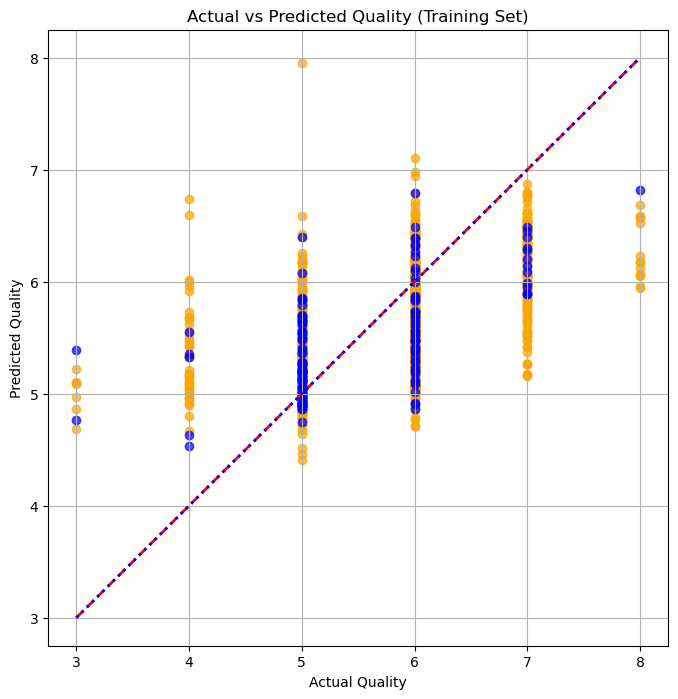

In [986]:
plt.figure(figsize=(8, 8))
plt.scatter(y_train, train_pred, alpha=0.7,color='orange')
plt.scatter(y_test, test_pred, alpha=0.7,color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b', lw=2, linestyle=':')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.title('Actual vs Predicted Quality (Training Set)')
plt.grid(True)
plt.show()